<h1><center> Hackathon Opioid Care </h1>

First let's undestand opioids crisis.

Opioid is group of drugs that are painkiller for severe pains. Some of well known opioids are morphine, codeine, heroin and fenatanyl. United States is confronting the most fatal drug crisis in U.S. history.
* 11 millions people misused an opioid pain reliever in past year (2017).
* 63,600 families lost loved ones to a drug overdose in 2016.
* U.S lifespan estimate declined for the second year in a row.
* Opioid over prescribing affecting economy by reducing number of workers.


<br><h2> Findings ( Factors that are driving growing opioid epidemic ) </h2>

* Male has more deaths due to drug abuse as compared to female but in both cases age-group which is highly affected due to this is between 25-34, 35-44 and 45-54 respectively.
* **West Virginia, Maryland, Ohio** are 3 most vulnerable states. All Top 10 states are from northeast region.
* **White and African American** between age of **25-54** are more prone to drug abuse and overdose.
* People who are affected most of the times are due to injuries or accidents, post surgery to treat severe pain.
* Individual who take opioids and don't have history of depression, anxiety and other mental illness are less likely to become addicted.
* Pain management and post surgery (hospitalization data), people don't realize how easy it can be to become addicted.
* Recreational drug use by youths.


<br><h2> Identified below key actions to overcome this epidemic ( Recommended actions to reduce opioid overdoses). </h2>

* Continuous education for prescriber and Implementing opioid prescribing guidelines.
* Improving data integartion platform for  drug monitonoring, collection and sharing program.
* Avaialability of opioid use disorder treatment. Medication Assisted Treatment should be available near area at high risk of opioid abuse.
* Implement programs and laws to expand access to Naloxone, a drug to treat opioid overdose.
* Availability of good education and Access to excercise facilities keep your brain free from mental pressure and reduce risk of opioid use.
* Low cost health care providers and care for children helps to overcome tension related to family.


<br><h2> Use case: Simulate opioid usage growth in different regions. </h2>

* Identify county or state which are at high risk based on demographics data, to open more Opioid Treatment centers. 
* Find out demographic and socio-economic factors which are good indicators of probability an individual abuse opioids such as Race and ethinicty, Gender and Age group, Employment status, Mariatal Status, Income, Education.
* Predict mortality rate based on different factors.

## Let's start exploring dataset...

In [1]:
#echo "pip install xlrd" >> /content/datalab/.config/startup.sh

# xlrd module is required to read data from excel. 
# Run it from below commented section if it is not installed already 
!pip install xlrd

  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/07/e6/e95c4eec6221bfd8528bcc4ea252a850bffcc4be88ebc367e23a1a84b0bb/xlrd-1.1.0-py2.py3-none-any.whl


In [2]:
# Import required libraries
import pandas as pd
pd.options.display.max_columns=75
pd.options.display.max_rows=75
pd.options.display.float_format='{:,.2f}'.format

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import google.datalab.storage as storage
bucket = storage.Bucket('opioid-care')

import google.datalab.bigquery as bq

from io import BytesIO
import os, sys

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# List out files for Cause of Death dataset
%gcs list --objects gs://opioid-care/raw-data/Cause-of-Death

Name,Type,Size,Updated
raw-data/Cause-of-Death/,application/x-www-form-urlencoded;charset=UTF-8,0,2018-10-30 17:58:52.513000+00:00
raw-data/Cause-of-Death/CDC_cause_of_death_by_demographics_and_state_20180606.xlsx,application/vnd.openxmlformats-officedocument.spreadsheetml.sheet,2036990,2018-10-31 03:07:27.219000+00:00
raw-data/Cause-of-Death/National_Opioid_Mortality_CDC_Wonder_2010-2016_20180430.csv,application/vnd.ms-excel,43204,2018-10-31 03:07:58.636000+00:00
raw-data/Cause-of-Death/State_Opioid_Mortality_Rates_byDrug_2010-2016.xlsx,application/vnd.openxmlformats-officedocument.spreadsheetml.sheet,423049,2018-10-30 18:05:52.578000+00:00


In [4]:
# Write resuable function to read from storage
def read_from_storage(object_name, delimiter=','):
  """
  object_name: Full path of file, e.g 'raw-data/Cause-of-Death/CDC_cause_of_death_by_demographics_and_state_20180606.xlsx')
  delimiter: Based on file e.g Default ',' '\t' '|'
  """
  global data, uri
  data = bucket.object(object_name)
  uri = data.uri
  %gcs read --object $uri --variable data
  if object_name.endswith('xlsx') or object_name.endswith('xls'):
    return pd.read_excel(BytesIO(data))
  return pd.read_csv(BytesIO(data), delimiter=delimiter)

In [5]:
# Read demographics data
death_by_demographics_df = read_from_storage('raw-data/Cause-of-Death/CDC_cause_of_death_by_demographics_and_state_20180606.xlsx')
death_by_demographics_df.shape
death_by_demographics_df.head(5)

(2356, 8)

,STATE_NAME,STATE_ABBREV,STATE_FIPS,YEAR,GENDER,GROUP,POPULATION,OPD_DRUGDEATHS
0,Alabama,AL,1,2010,Male,25-34 years,300140,26
1,Alabama,AL,1,2010,Male,35-44 years,303785,11
2,Alabama,AL,1,2010,Male,45-54 years,337828,14
3,Alabama,AL,1,2011,Female,45-54 years,352123,17
4,Alabama,AL,1,2011,Male,25-34 years,302589,15


In [6]:
# Adding another variable to calculate deathrate_per_10000 = OPD_DRUGDEATHS/POPULATION
death_by_demographics_df['DEATH_RATE_PER_10000'] = (death_by_demographics_df.OPD_DRUGDEATHS/death_by_demographics_df.POPULATION)*10000
death_by_demographics_df['MORTALITY_RATE'] = (death_by_demographics_df.OPD_DRUGDEATHS/death_by_demographics_df.POPULATION)*1000
death_by_demographics_df.head(5)

,STATE_NAME,STATE_ABBREV,STATE_FIPS,YEAR,GENDER,GROUP,POPULATION,OPD_DRUGDEATHS,DEATH_RATE_PER_10000,MORTALITY_RATE
0,Alabama,AL,1,2010,Male,25-34 years,300140,26,0.87,0.09
1,Alabama,AL,1,2010,Male,35-44 years,303785,11,0.36,0.04
2,Alabama,AL,1,2010,Male,45-54 years,337828,14,0.41,0.04
3,Alabama,AL,1,2011,Female,45-54 years,352123,17,0.48,0.05
4,Alabama,AL,1,2011,Male,25-34 years,302589,15,0.50,0.05


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


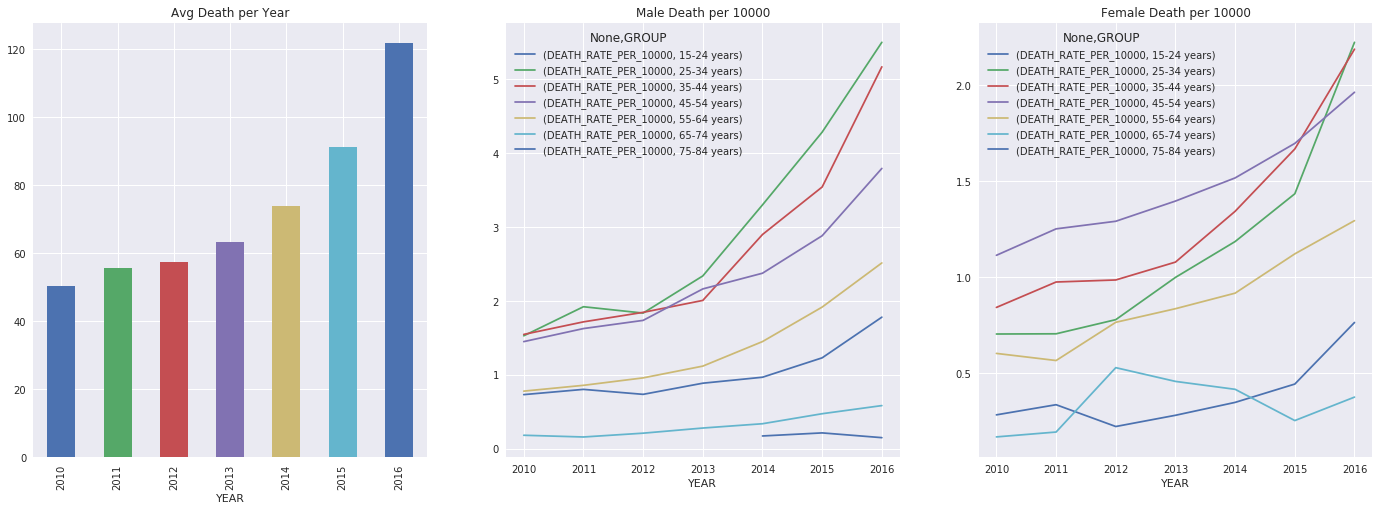

In [7]:
# Plot Avg Death Per year and Group based deaths
female_average_death_rate = pd.pivot_table(death_by_demographics_df[death_by_demographics_df['GENDER']=='Female'], ['DEATH_RATE_PER_10000'], index='YEAR', columns='GROUP')
male_average_death_rate = pd.pivot_table(death_by_demographics_df[death_by_demographics_df['GENDER']=='Male'], ['DEATH_RATE_PER_10000'], index='YEAR', columns='GROUP')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
ax1 = death_by_demographics_df.groupby('YEAR').mean()['OPD_DRUGDEATHS'].plot(ax = axes[0], kind='bar',
                                                                             title = 'Avg Death per Year')
ax2 = male_average_death_rate.plot(ax = axes[1], kind='line', title = 'Male Death per 10000', )
ax3 = female_average_death_rate.plot(ax = axes[2], kind='line', title = 'Female Death per 10000')

These chart shows that clear trend of increase in epidemic year by year. <br> 
Male has more deaths due to drug abuse as compared to female but in both cases age-group which is highly affected due to this is between 25-34, 35-44 and 45-54 respectively.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


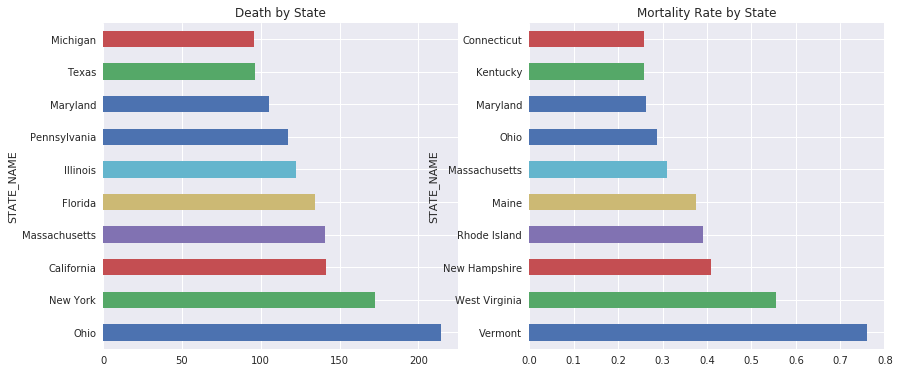

In [8]:
# Top 10 states in death rates
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1 = death_by_demographics_df.groupby(['STATE_NAME']).mean()['OPD_DRUGDEATHS'].sort_values(ascending=False)[:10].plot(ax = axes[0],
                                                                                                                       kind='barh', 
                                                                                                                       title = 'Death by State')

ax2 = death_by_demographics_df.groupby(['STATE_NAME']).mean()['MORTALITY_RATE'].sort_values(ascending=False)[:10].plot(ax = axes[1], 
                                                                                                                            kind='barh',
                                                                                                                             title = 'Mortality Rate by State')

Can we say Ohio, NewYork and California has more numbers because they are densely populated as compared to other state so a good crietria to check would be death per population. <br>
Based on density, we can say **West Virginia, Maryland, Ohio** are 3 most vulnerable states. All Top 10 states are from northeast region.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


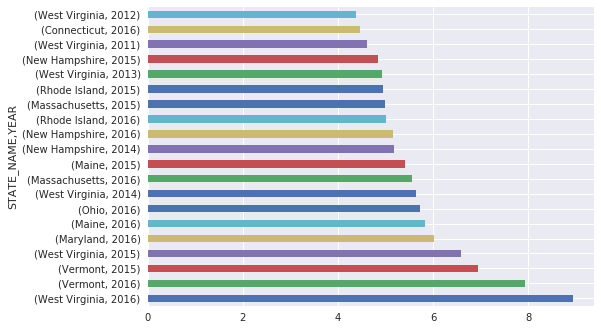

In [9]:
death_by_demographics_df.groupby(['STATE_NAME','YEAR']).mean()['DEATH_RATE_PER_10000'].sort_values(ascending=False)[:20].plot(kind='barh')

In [10]:
# Let's ingest another dataset from storage
mortality_df = read_from_storage('raw-data/Cause-of-Death/National_Opioid_Mortality_CDC_Wonder_2010-2016_20180430.csv')
mortality_df['Population'].dropna(inplace=True)
mortality_df.shape
mortality_df.head(5)

(517, 12)

,Ten-Year Age Groups,Ten-Year Age Groups Code,Gender,Gender Code,Race,Race Code,Year,Year Code,Deaths,Population,Crude Rate,Unnamed: 11
0,< 1 year,1,Female,F,American Indian or Alaska Native,1002-5,2015,2015,1,38745,Unreliable,nan
1,< 1 year,1,Female,F,Black or African American,2054-5,2010,2010,3,330352,Unreliable,nan
2,< 1 year,1,Female,F,Black or African American,2054-5,2011,2011,1,335326,Unreliable,nan
3,< 1 year,1,Female,F,Black or African American,2054-5,2012,2012,3,330701,Unreliable,nan
4,< 1 year,1,Female,F,Black or African American,2054-5,2013,2013,3,330884,Unreliable,nan


In [11]:
#mortality_df[mortality_df.Population != 'Not Applicable']['Population'].astype('int').mean()
#4307559.869822485

mortality_df.loc[mortality_df.Population == 'Not Applicable','Population'] = 4300000
mortality_df['Death_Rate'] = mortality_df.Deaths / mortality_df.Population.astype('int')

In [12]:
dict(zip(mortality_df['Ten-Year Age Groups'], mortality_df['Ten-Year Age Groups Code']))
dict(zip(mortality_df['Race'], mortality_df['Race Code']))
dict(zip(mortality_df['Year'], mortality_df['Year Code']))
mortality_df['Unnamed: 11'].unique()

{'1-4 years': '4-Jan',
 '15-24 years': '15-24',
 '25-34 years': '25-34',
 '35-44 years': '35-44',
 '45-54 years': '45-54',
 '5-14 years': '14-May',
 '55-64 years': '55-64',
 '65-74 years': '65-74',
 '75-84 years': '75-84',
 '85+ years': '85+',
 '< 1 year': '1',
 'Not Stated': 'NS'}

{'American Indian or Alaska Native': '1002-5',
 'Asian or Pacific Islander': 'A-PI',
 'Black or African American': '2054-5',
 'White': '2106-3'}

{2010: 2010,
 2011: 2011,
 2012: 2012,
 2013: 2013,
 2014: 2014,
 2015: 2015,
 2016: 2016}

array([nan])

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


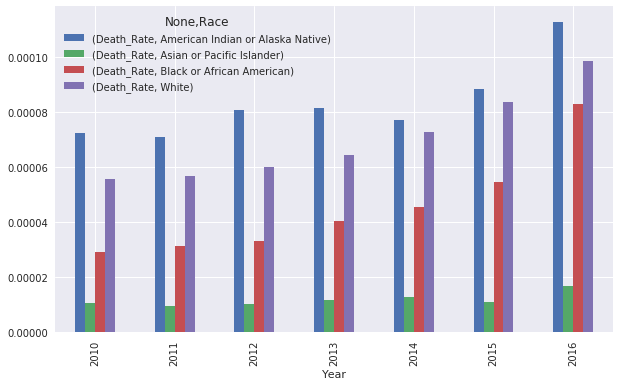

In [13]:
death_by_race = pd.pivot_table(mortality_df, ['Death_Rate'], index='Year', columns=['Race'])
death_by_race.plot(kind='bar',figsize=(10,6), label='Race') #, style='.-', markerfacecolor='black')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


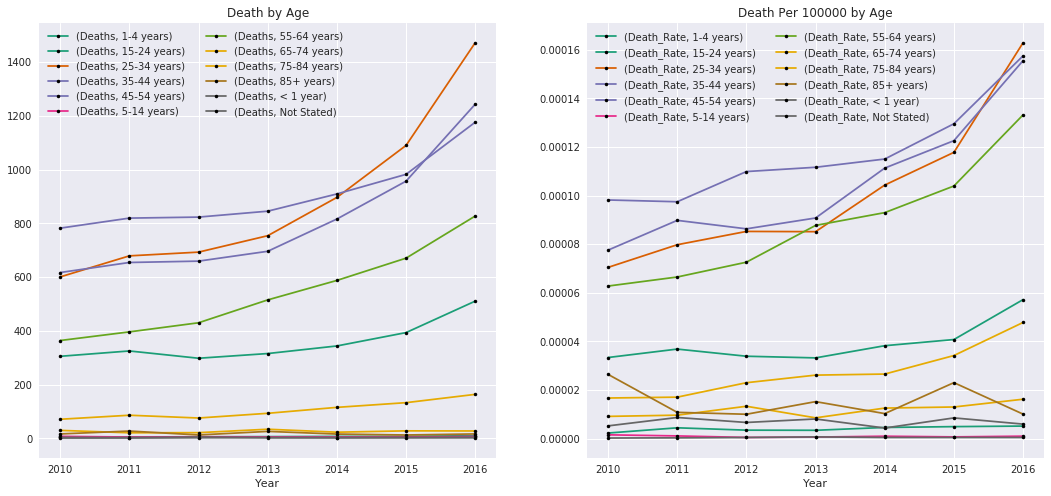

In [14]:
death_by_race = pd.pivot_table(mortality_df, ['Deaths'], index='Year', columns=['Ten-Year Age Groups'])
death_rate_by_race = pd.pivot_table(mortality_df, ['Death_Rate'], index='Year', columns=['Ten-Year Age Groups'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
ax1 = death_by_race.plot(ax = axes[0], kind='line', label='Age Group', fontsize=10, title = 'Death by Age', legend=True, colormap='Dark2', style='.-', markerfacecolor='black')
ax1.legend(loc='upper left', ncol=2)
ax2 = death_rate_by_race.plot(ax = axes[1], kind='line',label='Age Group', fontsize=10, title = 'Death Per 100000 by Age', legend=True, colormap='Dark2', style='.-', markerfacecolor='black')
ax2.legend(loc='upper left', ncol=2)
plt.show()

Based on above analysis, we can say that **White and African American** between age of **25-54** are more prone to drug abuse and overdose.

In [15]:
# Let's ingest another dataset from storage
drugs_df = read_from_storage('raw-data/Cause-of-Death/State_Opioid_Mortality_Rates_byDrug_2010-2016.xlsx')
drugs_df.shape
drugs_df.head(5)

(5508, 17)

,State,State Code,Year,Year Code,Multiple Cause of death,Multiple Cause of death Code,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Crude Rate Standard Error,Age Adjusted Rate,Age Adjusted Rate Lower 95% Confidence Interval,Age Adjusted Rate Upper 95% Confidence Interval,Age Adjusted Rate Standard Error,% of Total Deaths
0,Alabama,1,1999,1999,Opium,T40.0,Suppressed,4430141,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed
1,Alabama,1,1999,1999,Heroin,T40.1,Suppressed,4430141,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed,Suppressed
2,Alabama,1,1999,1999,Other opioids,T40.2,10,4430141,Unreliable,0.10,0.40,0.10,Unreliable,0.10,0.40,0.10,0
3,Alabama,1,1999,1999,Methadone,T40.3,16,4430141,Unreliable,0.20,0.60,0.10,Unreliable,0.20,0.60,0.10,0
4,Alabama,1,1999,1999,Other synthetic narcotics,T40.4,10,4430141,Unreliable,0.10,0.40,0.10,Unreliable,0.10,0.40,0.10,0


In [16]:
drugs_df.groupby('Multiple Cause of death').count()

,State,State Code,Year,Year Code,Multiple Cause of death Code,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Crude Rate Standard Error,Age Adjusted Rate,Age Adjusted Rate Lower 95% Confidence Interval,Age Adjusted Rate Upper 95% Confidence Interval,Age Adjusted Rate Standard Error,% of Total Deaths
Multiple Cause of death,,,,,,,,,,,,,,,,
Heroin,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918
Methadone,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918
Opium,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918
Other and unspecified narcotics,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918
Other opioids,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918
Other synthetic narcotics,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918


In [17]:
(drugs_df['Deaths']=='Suppressed').value_counts()
drugs_df_filtered = drugs_df.loc[drugs_df.Deaths !='Suppressed', ['Multiple Cause of death', 'Deaths']]
drugs_df_filtered.info()

False    3548
True     1960
Name: Deaths, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 2 to 5507
Data columns (total 2 columns):
Multiple Cause of death    3548 non-null object
Deaths                     3548 non-null object
dtypes: object(2)
memory usage: 83.2+ KB


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


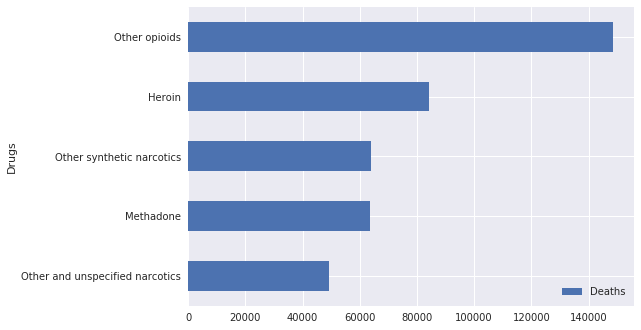

In [18]:
drugs_df_filtered.columns = ['Drugs', 'Deaths']
drugs_df_filtered.groupby('Drugs').sum().sort_values(by='Deaths').plot(kind='barh')

As you can see above highest death due to drug that is specified as **Other** :-) and second is Heroin.
This data doesn't give much information as per my understanding or am i missing something out of it. Let's discuss with team and find out.<br><br>
Now let's start exploring another dataset given.

In [19]:
%gcs list --objects gs://opioid-care/raw-data/Treatment-Locator

Name,Type,Size,Updated
raw-data/Treatment-Locator/,application/x-www-form-urlencoded;charset=UTF-8,0,2018-10-30 18:00:35.489000+00:00
raw-data/Treatment-Locator/Physician_Locator_2017-12-21T14-44-58.csv,application/vnd.ms-excel,3686949,2018-10-30 18:28:24.890000+00:00
raw-data/Treatment-Locator/Physician_Locator_2018-05-16T08-29-48.csv,application/vnd.ms-excel,3436214,2018-10-30 18:28:39.585000+00:00


In [20]:
treatment_loc_2017_df = read_from_storage("raw-data/Treatment-Locator/Physician_Locator_2017-12-21T14-44-58.csv")
treatment_loc_2017_df.shape
treatment_loc_2017_df.head(5)

(26826, 11)

,Unnamed: 0,First,Last,Deg.,Address,City,County,State,Postal Code,Tele.,Fax
0,NaN,Elizabeth,Alexander,NP,Keystone Substance Abuse Services195 S Herlong...,Rock Hill,NaN,South Carolina,29732,7818255752,NaN
1,NaN,Denise,Bouchard,NP,53 Schoodic Drive,Belfast,Waldo,Maine,04915,2073386900,2073386944
2,NaN,Beth,Canfield,NP,1320 Mercy Drive,Canton,Stark,Ohio,44708,330-479-1478,3304898162
3,NaN,Victoria,Habibi,NP,86-260 Farrington Hwy,Waianae,Honolulu County,Hawaii,96792,808-697-3300,NaN
4,Dr.,Mark,Ledesma,M.D.,11803 W North Avenue,Milwaukee,Milwaukee County,Wisconsin,53226,(414)258-5522,(414)258-1337


In [21]:
treatment_loc_2018_df = read_from_storage("raw-data/Treatment-Locator/Physician_Locator_2017-12-21T14-44-58.csv")
treatment_loc_2018_df.shape
treatment_loc_2018_df.head(5)

(26826, 11)

,Unnamed: 0,First,Last,Deg.,Address,City,County,State,Postal Code,Tele.,Fax
0,NaN,Elizabeth,Alexander,NP,Keystone Substance Abuse Services195 S Herlong...,Rock Hill,NaN,South Carolina,29732,7818255752,NaN
1,NaN,Denise,Bouchard,NP,53 Schoodic Drive,Belfast,Waldo,Maine,04915,2073386900,2073386944
2,NaN,Beth,Canfield,NP,1320 Mercy Drive,Canton,Stark,Ohio,44708,330-479-1478,3304898162
3,NaN,Victoria,Habibi,NP,86-260 Farrington Hwy,Waianae,Honolulu County,Hawaii,96792,808-697-3300,NaN
4,Dr.,Mark,Ledesma,M.D.,11803 W North Avenue,Milwaukee,Milwaukee County,Wisconsin,53226,(414)258-5522,(414)258-1337


In [22]:
treatment_loc_2017_df.isnull().sum()
treatment_loc_2018_df.isnull().sum()

treatment_loc_2017_df.describe()
treatment_loc_2018_df.describe()

Unnamed: 0     12452
First              0
Last               0
Deg.            2909
Address            0
City               0
County          3855
State              0
Postal Code        0
Tele.             48
Fax             4479
dtype: int64

Unnamed: 0     12452
First              0
Last               0
Deg.            2909
Address            0
City               0
County          3855
State              0
Postal Code        0
Tele.             48
Fax             4479
dtype: int64

,Unnamed: 0,First,Last,Deg.,Address,City,County,State,Postal Code,Tele.,Fax
count,14374,26826,26826,23917,26826,26826,22971,26826,26826,26778,22347
unique,2,6662,15220,249,23697,5190,1898,55,8095,22600,18778
top,Dr.,Michael,Patel,M.D.,2500 Alhambra Avenue,New York,Los Angeles County,California,94110,(724)591-5236,(724)591-5436
freq,14373,549,142,16015,20,579,499,2620,74,50,52


,Unnamed: 0,First,Last,Deg.,Address,City,County,State,Postal Code,Tele.,Fax
count,14374,26826,26826,23917,26826,26826,22971,26826,26826,26778,22347
unique,2,6662,15220,249,23697,5190,1898,55,8095,22600,18778
top,Dr.,Michael,Patel,M.D.,2500 Alhambra Avenue,New York,Los Angeles County,California,94110,(724)591-5236,(724)591-5436
freq,14373,549,142,16015,20,579,499,2620,74,50,52


In [23]:
def diff_pd(df1, df2):
    """Identify differences between two pandas DataFrames"""
    assert (df1.columns == df2.columns).all(), \
        "DataFrame column names are different"
    if any(df1.dtypes != df2.dtypes):
        "Data Types are different, trying to convert"
        df2 = df2.astype(df1.dtypes)
    if df1.equals(df2):
        return None
    else:
        # need to account for np.nan != np.nan returning True
        diff_mask = (df1 != df2) & ~(df1.isnull() & df2.isnull())
        ne_stacked = diff_mask.stack()
        changed = ne_stacked[ne_stacked]
        changed.index.names = ['id', 'col']
        difference_locations = np.where(diff_mask)
        changed_from = df1.values[difference_locations]
        changed_to = df2.values[difference_locations]
        return pd.DataFrame({'from': changed_from, 'to': changed_to},
                            index=changed.index)

In [24]:
# Find difference between 2 dataframes if any it will return those values else nothing
diff_pd(treatment_loc_2017_df, treatment_loc_2018_df)

Based on above statistics we cay say, there is no change of data from 2017 and 2018.

But me might need data from previous year to compare how treatment centers have been opened from last year.

This data tell us only about number of treatment center access in city and state, County has number of Nulls so we need to figure about based on state and city. 

In [25]:
treatment_center_count = pd.DataFrame(treatment_loc_2018_df.groupby(['State','County'])['Postal Code'].count()).reset_index()
treatment_center_count.columns = ['State', 'County', 'Treatment_Center_Count']
treatment_center_count[:5]

,State,County,Treatment_Center_Count
0,Alabama,Autauga County,2
1,Alabama,Baldwin,2
2,Alabama,Baldwin County,11
3,Alabama,Calhoun,1
4,Alabama,Calhoun County,6


In [26]:
# Let's get started with Counties data
%gcs list --objects gs://opioid-care/raw-data/RWJF

Name,Type,Size,Updated
raw-data/RWJF/,application/x-www-form-urlencoded;charset=UTF-8,0,2018-10-30 18:00:17.805000+00:00
raw-data/RWJF/county_health_rankings_2014.csv,application/vnd.ms-excel,1111337,2018-10-30 18:26:06.763000+00:00
raw-data/RWJF/county_health_rankings_2016.csv,application/vnd.ms-excel,2368831,2018-10-30 18:26:20.264000+00:00


In [27]:
# Read data for 2016 county health ranking
county_health_rankings_2016_df = read_from_storage('raw-data/RWJF/county_health_rankings_2016.csv')

# Read data for 2014 health ranking
county_health_rankings_2014_df = read_from_storage('raw-data/RWJF/county_health_rankings_2014.csv')

county_health_rankings_2016_df.shape
#county_health_rankings_2016_df.head(5)
#county_health_rankings_2014_df.shape
#county_health_rankings_2014_df.head(5)

(3141, 119)

In [28]:
# Let's start with preprocessing. As you see 2014 and 2016 dataframes have different shape.

print(" Columns not present in 2016 dataframe")
[col for col in county_health_rankings_2014_df.columns if col not in county_health_rankings_2016_df.columns]

print(" Columns not present in 2014 dataframe")
[col for col in county_health_rankings_2016_df.columns if col not in county_health_rankings_2014_df.columns]

 Columns not present in 2016 dataframe


['Mortality_rank_within_state',
 'Mortality_quartile_within_state',
 'Mortality_pctile_within_state',
 'Morbidity_rank_within_state',
 'Morbidity_quartile_within_state',
 'Morbidity_pctile_within_state',
 'YPPL_rate',
 'pct_No_Social_Emotional_Support',
 'pct_Pop_Drinking_Water_Violations',
 'pct_Couldnt_See_Doctor_Due_to_Cost']

 Columns not present in 2014 dataframe


['Length_of_Life_rank_within_state',
 'Length_of_Life_quartile_within_state',
 'Length_of_Life_pctile_within_state',
 'Quality_of_Life_rank_within_state',
 'Quality_of_Life_quartile_within_state',
 'Quality_of_Life_pctile_within_state',
 'Income_80th_Percentile',
 'Income_20th_Percentile',
 'Income_Ratio',
 'School_Association_Rate',
 'Presence_of_Drinking_Water_Violation',
 'num_Infant_Deaths',
 'pct_Frequent_Physical_Distress',
 'pct_Frequent_Mental_Distress',
 'num_Food_Insecure',
 'pct_Insufficient_Sleep',
 'Residential_Segregation_Index_1',
 'Residential_Segregation_Index_2',
 'num_African_American',
 'num_American_Indian',
 'num_Asian',
 'num_Pacific_Islander',
 'num_Hispanic',
 'num_Non_Hispanic_White',
 'num_Rural']

Mortality, Morbidity (Fequencey of diseases appear), YPPL Rate (Pre Mature death, age below 75), Percentage of couldn't see doctor due to cost are important variable in 2014 dataset but somehow directly related to deaths. Let's see if these are in some present in 2016 with other name.

Length_of_Life_pctile_within_state, Quality_of_Life_pctile_within_state, pct_Frequent_Physical_Distress, pct_Frequent_Mental_Distress' and pct_Insufficient_Sleep' are important variables in 2016 dataset.

Pct count't see doctor and HelathCare cost in 2016 dataset seems related.

So conclusion is that we can drop columns from 2014 but not from 2016 to do union. So will be using 2016 data onwards as it has latest ratings.

We will add treatment center count per county to counties dataframe.

In [29]:
counties_df = county_health_rankings_2016_df.merge(treatment_center_count, how='left', on=['State','County'])
counties_df['Treatment_Center_Count'].fillna(0, inplace=True)


In [30]:
counties_df.corr().loc[:,['Drug_Overdose_Mortality_Rate', 'num_Drug_Overdose_Deaths']].head(5)

,Drug_Overdose_Mortality_Rate,num_Drug_Overdose_Deaths
FIPS,0.06,-0.09
Num_ranked_counties_in_state,-0.09,-0.11
Health_Outcomes_rank_within_state,0.23,-0.12
Health_Outcomes_quartile_within_state,0.37,-0.07
Health_Outcomes_pctile_within_state,0.39,-0.06


In [31]:
#!gsutil cp gs://opioid-care/eda_output/Dashboard_Counties_Cluster.png ./eda_output/

Now let's plot counties based on different variables available to get good understanding of our dataset. <br>
To better visualize these data we need some interactive modules such as plotly which can show label and data on graphs.

I tried plotting counties data in Inteactive way using Plotly and Bokeh but they were taking more time and different module to install so i did my exploration in Tableau. Given below findings and link to dashboard.

I have updated link of dashboard after model validation and added result of different alogorithms into this. 

**[Opioid Care Counties Clusters and Exploration Dashboard](https://public.tableau.com/profile/pankaj.sharma1347#!/vizhome/OpioidCareCountiesCluster/CountiesEDA)**
<img src='./eda_output/Dashboard_Counties_Cluster.png' width="800" height="800" >




There are number of factors a.k.a columns to explore and we can do that one by one with our dashboard easily and SELECT list of important features for clustering. Let's get started.

**FIPS** Federal Information Processing Standards code which uniquely identified counties and county equivalents in the United States. We don't need this, it doesn't process any information just a sequence number for counties.

**Num ranked counties in state** Counties ranked across U.S but we are not sure based on which factors, could be healthcare services, let's drop it for now.

**Health Outcome Ranking within State** As you see in map, there are lot of amber in Texas bcoz there are more counties than other states so this variable would be useful if we do analysis with in state but not when clustering across U.S.

**Health Outcome Quartile and Percentile** seems coorelated, we can use one of them. It resolves our ranking issue within state.

**'Health_Outcomes_pctile_within_state', 'Health_Factors_rank_within_state','Health_Factors_quartile_within_state' OR<br>
'Length_of_Life_rank_within_state', 'Length_of_Life_quartile_within_state', 'Length_of_Life_pctile_within_state' OR<br>
'Quality_of_Life_rank_within_state', 'Quality_of_Life_quartile_within_state', 'Quality_of_Life_pctile_within_state' OR <br> 'Clinical_Care_rank_within_state','Clinical_Care_quartile_within_state', 'Clinical_Care_pctile_within_state' OR<br>
'Social_and_Economic_Factors_rank_within_state', 'Social_and_Economic_Factors_quartile_within_state', 'Social_and_Economic_Factors_pctile_within_state' ** 

shares same analysis so will take percentile from them.

**'Health_Behaviors_rank_within_state', 'Health_Behaviors_quartile_within_state', 'Health_Behaviors_pctile_within_state' OR
'Physical_Environment_rank_within_state','Physical_Environment_quartile_within_state', 'Physical_Environment_pctile_within_state'** Not good for analysis.

**Number of deaths** = California, Texas, Florida and New York are top 4 state in deaths. It could be due to population.
California-Los Angles, Illinois-Cook and Texas-Harris counties are top 3 in deaths resepectively. We will take it and will see if we have any variable with death due to opioid so it will help us to create a fraction.

**Percentage of Fair and Poor Health** Texas is surely not good in healthcare services :-). Will take it.

**Physciall or Mentally Unhealthy Days** seems coorleated to each other. For now let's use both. People with low mental health or suffering from mental disorder are more affected due to drugs.

**Low Birthweight** It might or might not be useful, let's our ML model decide on that. One more time Texas topped the list as State and Colrado-Jackson as county.

**Percentage of Smokers** It should be high indicator. People smoke in anxiety, they start with smoking and evenetually leds to drugs.

**Obese, Physically Inactive, access to excercise, excessive drinking** When you sit idle you will do something wrong. There is a saying in Hindi "Khali dimag, shaitan ka ghar":-) (Devil resides in empty mind).
On other hand it you do excercise or drinking, there is less chance to fall for drugs.

**Alcohol impaired  and Food Environment Index** Doesn't look a worthy variabales to me. Let's drop it.

**Chalmydia Rate** It is STD, oftely occur in young women. Let's see if there is no strong relation to drug related deaths.

**Teen Birth Rate** Low drug use when you have a child to play with, keeps you busy.

**num_Uninsured                                       -0.114080<br>
pct_Uninsured                                        0.116594<br>
num_Primary_Care_Physicians                         -0.128475<br>
Primary_Care_Physicians_rate                        -0.165460<br>
num_Dentists                                        -0.119247<br>
Dentists_rate                                       -0.177291<br>
num_Mental_Health_Providers                         -0.097668<br>
Mental_Health_Providers_rate                        -0.004453**

Doesn't have any corelation with drug related death but which is bit skeptical. Will see once we move towards complex model
but let's drop for now.

**Preventable_Hospitalization_rate** Strong relation with drug addiction.

**num_Diabetics & High_School_Graduation_rate** No relation

**pct_Mammography** It is technique to detect Breast Cancer, people won't use drug if they are diagnosed with cancer and will be at doctor's survelliance. Let's take it.

**pct_Some_College** Decrease of opioid use when people are educated.

**pct_Unemployed** Unemployment increases chance of mental pressure, depression and inturn drug use.

**pct_Children_in_Poverty** Poverty can also be a factor.

**Income_80th_Percentile                              -0.318705<br>
Income_20th_Percentile                              -0.316330<br>
Income_Ratio                                         0.145766**
I am not sure which basis these percentiles are and income ration doesn't show are relation so will take Income_80th and drop others.

**pct_Single_Parent_Households                         0.102618<br>
School_Association_Rate                             -0.025660<br>
num_Violent_Crimes                                  -0.078352<br>
Violent_Crime_rate                                  -0.016234**
No realtion as such, let's drop them as well. My knowledge says, people do crime when they are high but that might be other drugs not opioid so there is little decrease in opioid death when crime is voilent. Let's drop them for now.

**Average_Daily_PM2pt5                                 0.201380 # Not sure what is this<br>
pct_Severe_Housing_Problems                         -0.162394<br>
pct_Drive_Alone                                      0.115217<br>
pct_Long_CommuteDrives_Alone                         0.099688** Drop them<br>

**Child_Mortality_Rate                                 0.277945<br>
pct_Frequent_Physical_Distress                       0.414351<br>
pct_Frequent_Mental_Distress                         0.401079<br>
pct_Diabetic                                         0.355054<br>
num_Drug_Overdose_Deaths                             0.012274<br>
Health_Care_Costs                                    0.247288<br>
Median_Household_Income                             -0.332253<br>
pct_Children_Eligible_Free_Lunch                     0.262955 # This is interesting<br>
pct_African_American                                -0.200920<br>
Population                                          -0.129630<br>
pct_Under_18                                        -0.131835<br>
pct_65_and_Older                                     0.236981<br>
pct_Asian                                           -0.221506<br>
pct_Rural                                            0.310179<br>
pct_Insufficient_Sleep                               0.249238 # Lack of sleep, Insomaniac<br>
pct_Not_Proficient_in_English                       -0.211951**<br>

We will use above variables and drop rest below. Most of them are self explanatory.

**Age_Adjusted_Mortality                               0.548278<br>
Injury_Death_Rate                                    0.699089 # Doctor presribe medicine for major injuries which affect brain when use for a long time. <br>
Motor_Vehicle_Mortality_Rate                         0.400859 # Again injury, related to prescription.<br>
num_Child_Deaths                                    -0.093039<br>
num_Infant_Deaths                                   -0.066123<br>
Infant_Mortality_Rate                                0.190772<br>
num_HIV_Cases                                       -0.087092<br>
HIV_Prevalence_Rate                                 -0.122894<br>
num_Food_Insecure                                   -0.112142<br>
pct_Food_Insecure                                    0.156365<br>
num_Limited_Access_Healthy_Food                     -0.131125<br>
pct_Limited_Access_Healthy_Food                     -0.001876<br>
pct_Rural                                            0.310179<br>
pct_Non_Hispanic_White                               0.243280<br>
num_Motor_Vehicle_Deaths                            -0.112516<br>
num_Uninsured_Adults                                -0.112652<br>
pct_Uninsured_Adults                                 0.109819<br>
num_Uninsured_Children                              -0.120292<br>
pct_Uninsured_Children                               0.022043<br>
Residential_Segregation_Index_1                      0.078476<br>
Residential_Segregation_Index_2                     -0.007473<br>
Homicide_Rate                                        0.153161<br>
num_African_American                                -0.108238<br>
num_American_Indian                                 -0.071319<br>
pct_American_Indian                                  0.061370<br>
num_Asian                                           -0.106260<br>
num_Pacific_Islander                                -0.065536<br>
pct_Pacific_Islander                                -0.059146<br>
num_Hispanic                                        -0.104656<br>
pct_Hispanic                                        -0.127045<br>
num_Non_Hispanic_White                              -0.127504<br>
num_Not_Proficient_in_English                       -0.102750<br>
pct_Female                                          -0.019480<br>
num_Rural                                           -0.161628<br>
**


Based on dashboard and coorelation, we have selected features but there is always scope for feature engineering. But for now let's start building clustering model.

After looking into heatmap, after our initial analysis, we caught some corelated variables and removed from our features and plotted again as below.
Num of child Deaths and Number of Deaths,
income_80 percentile 
Physical, Mental distress


You know what this heatmap tells us that if you have **Good Education, Access to Excerices or Sport, Good Income and Drink Habits** :-), you are immune from opioid use.
There is one more factor mammogrpahy which is kind of breast cancer, but this is neither we can build to improve opioid crisis nor we want to.

In [32]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia': 'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [33]:
# Let's rename columns
counties_df.columns = counties_df.columns.str.lower().str.replace(' ', '_').str.replace('(','_').str.replace(')','_').str.replace(';','_').str.replace('-','_')

In [34]:
counties_df['state_name'] = counties_df['state']
counties_df['state'] = counties_df['state'].map(us_state_abbrev)

In [35]:
numerical_cols = list(counties_df.select_dtypes(['number']))
categorical_cols = list(counties_df.select_dtypes(['object']))
categorical_cols

['state', 'county', 'presence_of_drinking_water_violation', 'state_name']

In [36]:
# Find columns with nan, null in dataframe
#counties_df[numerical_cols].loc[:, counties_df[numerical_cols].isna().any()]

In [37]:
np.unique(counties_df[numerical_cols].isin([np.nan, np.inf, -np.inf]).any(1))

array([False,  True])

In [38]:
# Based on our EDA, feature engineering and multiple test we figured out below features are good representation of our data...
target = ['drug_overdose_mortality_rate']
categorical_cols = ['state']
numerical_cols = [
'mentally_unhealthy_days',
 'physically_unhealthy_days',
 'pct_frequent_mental_distress',
 'pct_excessive_drinking',
 'injury_death_rate',
 'age_adjusted_mortality',
 'pct_frequent_physical_distress',
 'pct_smokers',
 'pct_insufficient_sleep',
 'preventable_hospitalization_rate',
 'pct_some_college',
 'pct_fair_or_poor_health',
 'pct_unemployed',
 'length_of_life_pctile_within_state',
 'median_household_income',
 'pct_physically_inactive',
'length_of_life_quartile_within_state',
 'pct_children_in_poverty',
 'income_20th_percentile',
 'pct_children_eligible_free_lunch',
 'pct_diabetic']
dropped_columns = [col for col in np.array(counties_df.select_dtypes(['number']).columns) if col not in numerical_cols + categorical_cols + target]

In [39]:
# Remove outlier from columns 
def remove_outliers(df, numerical_cols):
  for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range

    fence_low  = q1-1.5*iqr
    fence_high = q3 + 1.5*iqr
    
    #print(col, "Max:",df[col].max(), "Min:",df[col].min(), "q1:", q1, "q3:", q3, "iqr:", iqr, "low:",fence_low, "high:", fence_high)
    
    df[col] = df[col].mask(df[col] > fence_high, fence_high)
    df[col] = df[col].mask(df[col] < fence_low, fence_low)
  return df
  
counties_df = remove_outliers(counties_df, numerical_cols + target)

In [40]:
# Let's impute value based on average by State
def imputer(df, numerical_cols):
  for col in numerical_cols:
    grouped_dict = dict(df.groupby('state')[col].mean())
    df[col].fillna(df['state'].map(grouped_dict), inplace=True)
  return df

counties_df = imputer(counties_df, numerical_cols + target)

def target_imputer(df, col):
  grouped_dict = dict(df.groupby('state')[col].median())
  df[col].fillna(df['state'].map(grouped_dict), inplace=True)
  return df

counties_df = imputer(counties_df, numerical_cols)
counties_df = target_imputer(counties_df, target)
counties_df.head(5)

,fips,state,county,num_ranked_counties_in_state,health_outcomes_rank_within_state,health_outcomes_quartile_within_state,health_outcomes_pctile_within_state,health_factors_rank_within_state,health_factors_quartile_within_state,health_factors_pctile_within_state,length_of_life_rank_within_state,length_of_life_quartile_within_state,length_of_life_pctile_within_state,quality_of_life_rank_within_state,quality_of_life_quartile_within_state,quality_of_life_pctile_within_state,health_behaviors_rank_within_state,health_behaviors_quartile_within_state,health_behaviors_pctile_within_state,clinical_care_rank_within_state,clinical_care_quartile_within_state,clinical_care_pctile_within_state,social_and_economic_factors_rank_within_state,social_and_economic_factors_quartile_within_state,social_and_economic_factors_pctile_within_state,physical_environment_rank_within_state,physical_environment_quartile_within_state,physical_environment_pctile_within_state,num_deaths,pct_fair_or_poor_health,physically_unhealthy_days,mentally_unhealthy_days,pct_low_birthweight,pct_smokers,pct_obese,food_environment_index,pct_physically_inactive,...,num_drug_overdose_deaths,drug_overdose_mortality_rate,num_motor_vehicle_deaths,motor_vehicle_mortality_rate,pct_insufficient_sleep,num_uninsured_adults,pct_uninsured_adults,num_uninsured_children,pct_uninsured_children,health_care_costs,median_household_income,pct_children_eligible_free_lunch,residential_segregation_index_1,residential_segregation_index_2,homicide_rate,population,pct_under_18,pct_65_and_older,num_african_american,pct_african_american,num_american_indian,pct_american_indian,num_asian,pct_asian,num_pacific_islander,pct_pacific_islander,num_hispanic,pct_hispanic,num_non_hispanic_white,pct_non_hispanic_white,num_not_proficient_in_english,pct_not_proficient_in_english,pct_female,num_rural,pct_rural,treatment_center_count,state_name
0,1001,AL,Autauga,67,10.00,1.00,15.00,6.00,1.00,9.00,18.00,2.00,27.00,6.00,1.00,9.00,7.00,1.00,11.00,11.00,1.00,17.00,4.00,1.00,6.00,47.00,3.00,71.00,809.00,19.40,4.40,4.30,8.79,18.70,30.90,7.10,28.70,...,13.00,7.82,75.00,19.72,37.60,"5,852.00",17.48,563.00,3.86,"10,165.85","54,366.00",36.95,32.84,28.53,5.10,"55,395.00",25.18,13.83,"10,245.00",18.49,275.00,0.50,603.00,1.09,56.00,0.10,"1,514.00",2.73,"41,877.00",75.60,249.00,0.48,51.36,22921,42.00,0.00,Alabama
1,1003,AL,Baldwin,67,2.00,1.00,3.00,4.00,1.00,6.00,4.00,1.00,6.00,2.00,1.00,3.00,2.00,1.00,3.00,9.00,1.00,14.00,5.00,1.00,8.00,64.00,4.00,96.00,"2,506.00",16.00,4.10,4.20,8.51,18.60,26.70,7.60,25.20,...,94.00,16.03,204.00,15.90,32.80,"25,253.00",22.07,"2,586.00",5.71,"9,489.87","49,626.00",36.16,47.07,34.72,3.80,"200,111.00",22.16,18.68,"18,802.00",9.40,"1,488.00",0.74,"1,817.00",0.91,128.00,0.06,"9,130.00",4.56,"166,093.00",83.00,"2,571.00",1.43,51.23,77060,42.28,2.00,Alabama
2,1005,AL,Barbour,67,24.00,2.00,36.00,55.00,4.00,83.00,10.00,1.00,15.00,46.00,3.00,69.00,57.00,4.00,86.00,25.00,2.00,38.00,56.00,4.00,84.00,48.00,3.00,72.00,410.00,25.70,4.90,4.70,12.15,21.40,40.80,5.10,32.90,...,nan,14.44,35.00,18.22,39.60,"3,127.00",22.51,306.00,5.13,"10,077.19","34,971.00",55.06,30.79,25.66,4.50,"26,887.00",21.17,16.49,"12,689.00",47.19,159.00,0.59,132.00,0.49,47.00,0.17,"1,219.00",4.53,"12,525.00",46.58,549.00,2.15,46.61,18613,67.79,0.00,Alabama
3,1007,AL,Bibb,67,43.00,3.00,65.00,31.00,2.00,47.00,44.00,3.00,66.00,41.00,3.00,62.00,46.00,3.00,69.00,29.00,2.00,44.00,25.00,2.00,38.00,25.00,2.00,38.00,414.00,22.00,4.80,4.60,12.42,21.00,40.10,7.40,33.20,...,10.00,14.79,38.00,23.92,40.60,"2,388.00",19.01,209.00,4.25,"10,674.38","39,546.00",54.96,40.56,40.01,7.40,"22,506.00",21.02,14.79,"4,931.00",21.91,95.00,0.42,50.00,0.22,29.00,0.13,474.00,2.11,"16,772.00",74.52,112.00,0.52,45.93,15663,68.35,0.00,Alabama
4,1009,AL,Blount,67,8.00,1.00,12.00,18.00,2.00,27.00,12.00,1.00,18.00,7.00,1.00,11.00,9.00,1.00,14.00,39.00,3.00,59.00,13.00,1.00,20.00,19.00,2.00,29.00,876.00,20.70,4.60,4.50,7.47,19.40,32.40,8.30,28.50,...,42.00,24.22,99.00,24.67,36

In [41]:
#counties_df[['state','county', 'drug_overdose_mortality_rate']][counties_df['state'].isin(['KY'])].head(10)

In [42]:
# Something wrong with these columns even after impuatation these are having nan...let's delete them for now
"""
del counties_df['average_daily_pm2pt5']
del counties_df['num_hiv_cases']
del counties_df['hiv_prevalence_rate']
"""

"\ndel counties_df['average_daily_pm2pt5']\ndel counties_df['num_hiv_cases']\ndel counties_df['hiv_prevalence_rate']\n"

In [43]:
# Let's plot and find out variables distribution and anamoly detection
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
#  df = df.select_dtypes(include=[np.number])
#  df = df[[col for col in df if df[col].nunique>1]] # Keep columns with continuous values
#  columnNames = list(df)
  
  ax = pd.plotting.scatter_matrix(df, alpha=0.5, figsize=[plotSize, plotSize] , diagonal='kde', grid=True)
  #Change label rotation
  [s.xaxis.label.set_rotation(45) for s in ax.reshape(-1)]
  [s.yaxis.label.set_rotation(0) for s in ax.reshape(-1)]

  #May need to offset label when rotating to prevent overlap of figure
  [s.get_yaxis().set_label_coords(-0.8,0.5) for s in ax.reshape(-1)]

  #Hide all ticks
  [s.set_xticks(()) for s in ax.reshape(-1)]
  [s.set_yticks(()) for s in ax.reshape(-1)]
  corrs = df.corr().values
  for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
    ax[i, j].annotate('%.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
  plt.suptitle('Scatter and Density Plot')
  plt.savefig('eda_output/scatter_plot.png')
  plt.show()

#plotScatterMatrix(counties_df[numerical_cols + target], 20,8)

<img src='eda_output/scatter_plot.png' width="1500" height="1500" >

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


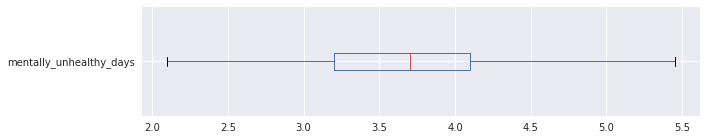

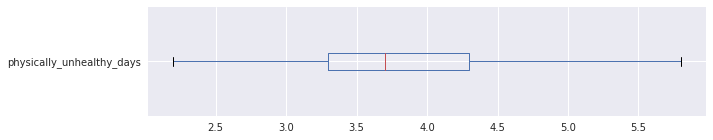

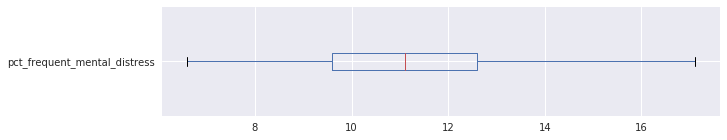

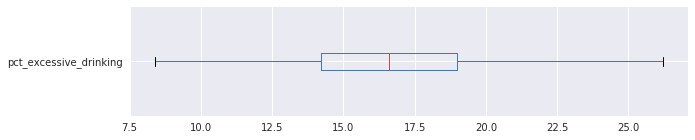

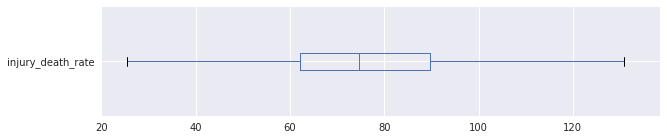

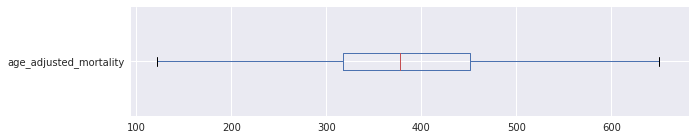

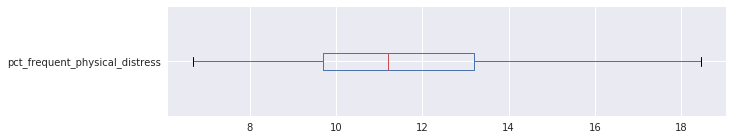

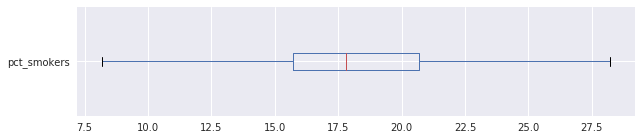

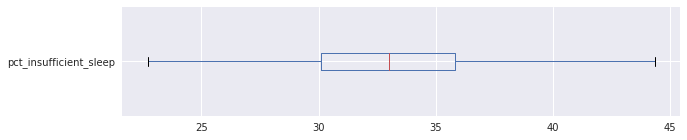

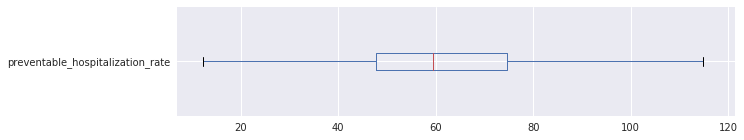

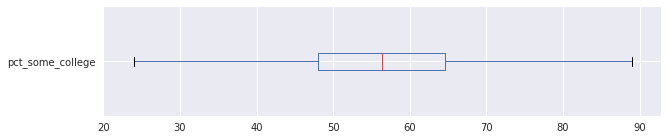

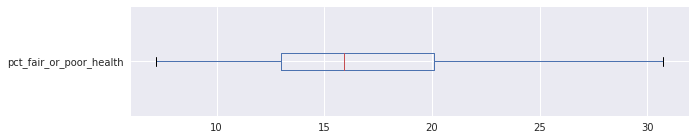

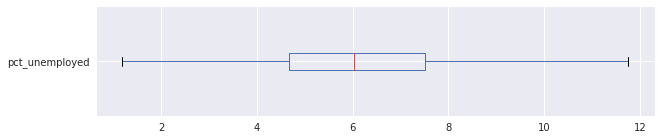

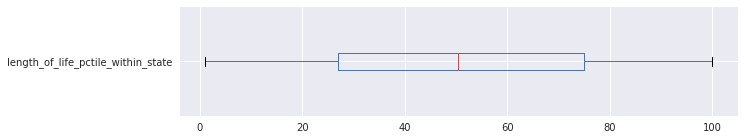

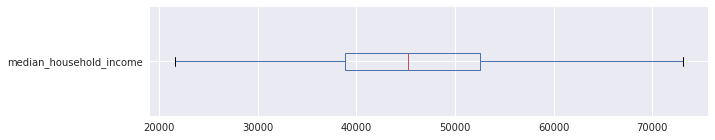

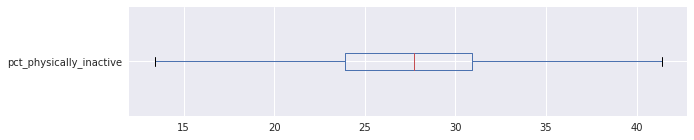

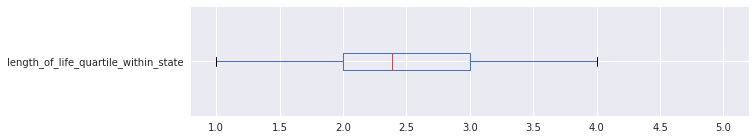

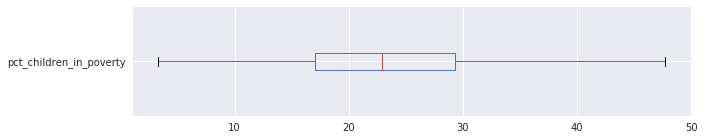

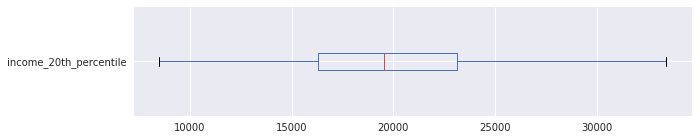

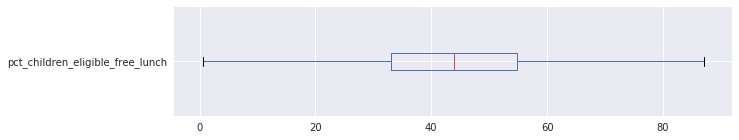

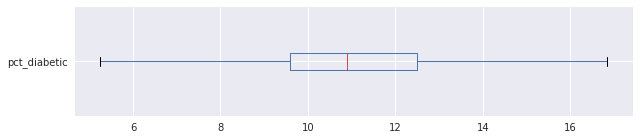

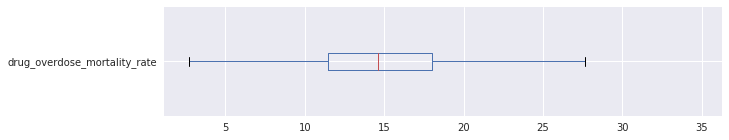

In [44]:
# plot outliers and find 
def plot_outliers(df, cols):
  for i in list(df[cols]):
    plt.figure(figsize=(10,2))
    df[i].plot.box(return_type='both', layout=(3,5), vert=False)
    plt.show()
    
plot_outliers(counties_df, numerical_cols + target)

In [45]:
#Caution:  **AUTOSAVE** will not work when you generate heatmap so i saved it into file and load that...
"""
fig, ax = plt.subplots(figsize=(20,15)) 
sns_plot = sns.heatmap(counties_df[numerical_cols + target].corr(), annot=True, linewidths=.5, ax=ax)
fig = sns_plot.get_figure()
fig.savefig('eda_output/coorelation_heatmap.png
"""


"\nfig, ax = plt.subplots(figsize=(20,15)) \nsns_plot = sns.heatmap(counties_df[numerical_cols + target].corr(), annot=True, linewidths=.5, ax=ax)\nfig = sns_plot.get_figure()\nfig.savefig('eda_output/coorelation_heatmap.png\n"

<img src='eda_output/coorelation_heatmap.png'>

In [46]:
# Let's try with all cols and then selected features
counties_data = counties_df[numerical_cols]
train = counties_data.values
train.shape

(3141, 21)

In [47]:
# Preprocess our data, we will we doing mean imputation and standarization
def preprocessing(data, strategy='mean', scaling='std'):
  from sklearn.preprocessing import Imputer, StandardScaler
  data = Imputer(strategy=strategy).fit_transform(data)
  if scaling=='std':
    data = StandardScaler().fit_transform(data)
  return data
  
prep_train = preprocessing(train)
prep_train.shape

(3141, 21)

Text(0.5,1,'Elbow Method')

Text(0.5,0,'Number of Clusters')

Text(0,0.5,'WCSS')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


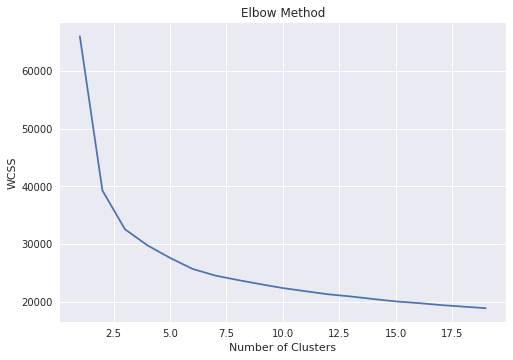

In [48]:
# Determine right number of clusters\
from sklearn.cluster import KMeans

wcss = []
rng_clusters=20

def find_nb_cluster(rng_clusters):
  for i in range(1, rng_clusters):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++', 
                    max_iter=300, 
                    n_init=10, 
                    random_state=0)
    kmeans.fit(prep_train)
    wcss.append(kmeans.inertia_)

find_nb_cluster(rng_clusters)

# Find optimized number of clusters
plt.plot(range(1, rng_clusters), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

array([0.60188163, 0.10410969])

Text(0.5,1,'Counties Clusters')

Text(0.5,0,'PCA 1')

Text(0.5,0,'PCA 2')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


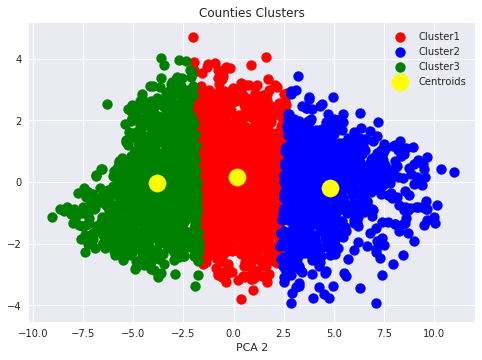

In [49]:
# Let's decompose data for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_train = pca.fit_transform(prep_train)
explained_variance = pca.explained_variance_ratio_
explained_variance

pca_kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_pca_kmeans = pca_kmeans.fit_predict(pca_train)


plt.scatter(pca_train[y_pca_kmeans==0,0], pca_train[y_pca_kmeans == 0, 1], s=100, c='red', label='Cluster1')
plt.scatter(pca_train[y_pca_kmeans==1,0], pca_train[y_pca_kmeans == 1, 1], s=100, c='blue', label='Cluster2')
plt.scatter(pca_train[y_pca_kmeans==2,0], pca_train[y_pca_kmeans == 2, 1], s=100, c='green', label='Cluster3')
plt.scatter(pca_kmeans.cluster_centers_[:,0], pca_kmeans.cluster_centers_[:,1], s=300, c='yellow', label = 'Centroids')
plt.title('Counties Clusters')
plt.xlabel('PCA 1')
plt.xlabel('PCA 2')
plt.legend()
plt.show()

In [50]:
# Function to write dataframe to cloud storage
def write_to_storage(bucket_obj, df):
    """
    This function is created to write data to storage
    bucket_obj: Actual path of file
    data: Dataframe or file
    """
    try:
        global bucket_object, data
        bucket_object = bucket_obj
        data = df
        %storage write --object $bucket_object --variable data
        print("Dataframe written successfully to storage")
    except IOError:
        print("Write operation failed")

# I experienced some issue with writing dataframe directly to storage

In [51]:
# Write features to storage
#input_features_bucket_obj = 'gs://opioid-care/eda_output/master_data.csv'
#write_to_storage(input_features_bucket_obj, features_df)

In [52]:
master_df = counties_df[['state',  'state_name', 'county'] + numerical_cols + target]
master_df.to_csv('eda_output/master_data.csv', index = False)

!gsutil cp 'eda_output/master_data.csv' 'gs://opioid-care/eda_output/master_data.csv'

Copying file://eda_output/master_data.csv [Content-Type=text/csv]...
/ [1 files][543.1 KiB/543.1 KiB]                                                
Operation completed over 1 objects/543.1 KiB.                                    


In [53]:
# Write data to Bigquery

project = 'opioid-care'
bq_dataset = 'hackathon_opioid'

def write_to_bigquery(df, project, bq_dataset, bq_table):
    # Define BigQuery dataset and table
    dataset = bq.Dataset(bq_dataset)
    table = bq.Table(bq_dataset + '.' + bq_table)

    # Create BigQuery dataset
    if not dataset.exists():
        dataset.create()

    # Create or overwrite the existing table if it exists
    table_schema = bq.Schema.from_data(df)
    table.create(schema = table_schema, overwrite = True)

    # Write the DataFrame to a BigQuery table
    try:
        table.insert(df)
        print("Table successfully written to BigQuery")
    except IOError as e:
        print(e, "Write operation failed")

In [54]:
# Write features to bigquery table
write_to_bigquery(master_df, project, bq_dataset, 'master_data')

Table successfully written to BigQuery


In [55]:
# Data wrangling done by Yiqi writing into BQ
best_features = pd.read_csv('eda_output/100_Best_Features.csv')
best_features.columns = best_features.columns.str.lower().str.replace(' ', '_').str.replace('(','_').str.replace(')','_').str.replace(';','_').str.replace('-','_')
best_features.shape

(3141, 103)

In [56]:
write_to_bigquery(best_features, project, bq_dataset, 'best_features')

Table successfully written to BigQuery


In [57]:
normalized_df = master_df[numerical_cols + target].apply(lambda x: (x-x.min())/(x.max() - x.min()), axis = 0)

In [58]:
write_to_bigquery(best_features, project, bq_dataset, 'normalized_master_data')

Table successfully written to BigQuery


This conclude our exploratory analysis we have marked down our research and ananlysis in starting on this notebook....